# House price analysis - version 4 
My notebook for [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?userId=1075113) competition

## Credit: Many thanks to:
- Pedro Marcelino [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

- Sergei Neviadomski [How to get to TOP 25% with Simple Model (sklearn)](https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn)

- juliencsA [study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- BradenFitz-Gerald [RandomForestRegressor](https://www.kaggle.com/dfitzgerald3/randomforestregressor)
- Tanner Carbonati [Detailed Data Analysis & Ensemble Modeling] (https://www.kaggle.com/tannercarbonati/detailed-data-analysis-ensemble-modeling/comments/notebook)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBRegressor
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

c:\users\le anh tuan\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\le anh tuan\appdata\local\programs\python\python35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load and combine data

In [101]:
# Load data. Download from:https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [102]:
# Combine data
# Initial features
o_features = eval_data.columns.values
# Store eval_id
eval_data_id = eval_data['Id']
#Seperate input and label from train_data
input_data = train_data[o_features]
#input_data.head(5)
#Combine train + eval data
combine_data = pd.concat([input_data, eval_data], keys=['train','eval'])
combine_data.head(5)
data = combine_data

# Fill NaN values

### Check NaN columns

In [5]:
def check_null_data():
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [6]:
miss_data_cols = check_null_data()
print(miss_data_cols)

              Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF1        1  0.000343
Exterior1st       1  0.000343
Exterior2nd       1  0.000343
BsmtFinSF2        1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea

### Check string columns

In [7]:
object_data = combine_data[miss_data_cols].select_dtypes(include=['object'])
object_data.head(20)

PoolQC MiscFeature Alley  Fence FireplaceQu GarageCond GarageQual  \
train 0     NaN         NaN   NaN    NaN         NaN         TA         TA   
      1     NaN         NaN   NaN    NaN          TA         TA         TA   
      2     NaN         NaN   NaN    NaN          TA         TA         TA   
      3     NaN         NaN   NaN    NaN          Gd         TA         TA   
      4     NaN         NaN   NaN    NaN          TA         TA         TA   
      5     NaN        Shed   NaN  MnPrv         NaN         TA         TA   
      6     NaN         NaN   NaN    NaN          Gd         TA         TA   
      7     NaN        Shed   NaN    NaN          TA         TA         TA   
      8     NaN         NaN   NaN    NaN          TA         TA         Fa   
      9     NaN         NaN   NaN    NaN          TA         TA         Gd   
      10    NaN         NaN   NaN    NaN         NaN         TA         TA   
      11    NaN         NaN   NaN    NaN          Gd         TA         TA   
      12    NaN         NaN   NaN    NaN         NaN         TA         TA   
      13    NaN         NaN   NaN    NaN          Gd         TA         TA   
      14    NaN         NaN   NaN   GdWo          Fa         TA         TA   
      15    NaN         NaN   NaN  GdPrv         NaN         TA         TA   
      16    NaN        Shed   NaN    NaN          TA         TA         TA   
      17    NaN        Shed   NaN    NaN         NaN         TA         TA   
      18    NaN         NaN   NaN    NaN         NaN         TA         TA   
      19    NaN         NaN   NaN  MnPrv         NaN         TA         TA   

         GarageFinish GarageType BsmtCond     ...     BsmtFinType1 MasVnrType  \
train 0           RFn     Attchd       TA     ...              GLQ    BrkFace   
      1           RFn     Attchd       TA     ...              ALQ       None   
      2           RFn     Attchd       TA     ...              GLQ    BrkFace   
      3           Unf     Detchd       Gd     ...              ALQ       None   
      4           RFn     Attchd       TA     ...              GLQ    BrkFace   
      5           Unf     Attchd       TA     ...              GLQ       None   
      6           RFn     Attchd       TA     ...              GLQ      Stone   
      7           RFn     Attchd       TA     ...              ALQ      Stone   
      8           Unf     Detchd       TA     ...              Unf       None   
      9           RFn     Attchd       TA     ...              GLQ       None   
      10          Unf     Detchd       TA     ...              Rec       None   
      11          Fin    BuiltIn       TA     ...              GLQ      Stone   
      12          Unf     Detchd       TA     ...              ALQ       None   
      13          RFn     Attchd       TA     ...              Unf      Stone   
      14          RFn     Attchd       TA     ...              BLQ    BrkFace   
      15          Unf     Detchd       TA     ...              Unf       None   
      16          Fin     Attchd       TA     ...              ALQ    BrkFace   
      17          Unf    CarPort      NaN     ...              NaN       None   
      18          Unf     Detchd       TA     ...              GLQ       None   
      19          Unf     Attchd       TA     ...              LwQ       None   

         MSZoning Utilities Functional Exterior1st Exterior2nd SaleType  \
train 0        RL    AllPub        Typ     VinylSd     VinylSd       WD   
      1        RL    AllPub        Typ     MetalSd     MetalSd       WD   
      2        RL    AllPub        Typ     VinylSd     VinylSd       WD   
      3        RL    AllPub        Typ     Wd Sdng     Wd Shng       WD   
      4        RL    AllPub        Typ     VinylSd     VinylSd       WD   
      5        RL    AllPub        Typ     VinylSd     VinylSd       WD   
      6        RL    AllPub        Typ     VinylSd     VinylSd       WD   
      7        RL    AllPub        Typ     HdBoard     HdBoard      

### PoolQC

train  0    NaN
       1    NaN
       2    NaN
       3    NaN
       4    NaN
Name: PoolQC, dtype: object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FAE1983208>], dtype=object)

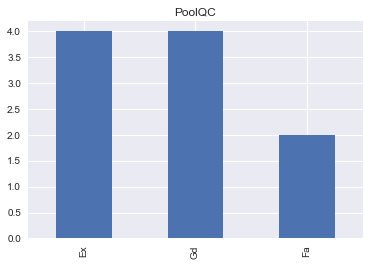

In [8]:
# PoolQC
col = 'PoolQC'
print(object_data[col].head(5))
object_data[col].value_counts().plot(kind='bar', subplots=True)

In [33]:
# Check NaN PoolQC with PoolArea
combine_data[['Id', col, 'PoolArea']][(combine_data[col].isnull()) & (combine_data['PoolArea']>0)]

Id PoolQC  PoolArea
eval 960   2421    NaN       368
     1043  2504    NaN       444
     1139  2600    NaN       561

In [36]:
#Check AVG PoolArea by PoolQC
combine_data[[col, 'PoolArea']].groupby(col).mean()

,PoolArea
PoolQC,
Ex,359.75
Fa,583.50
Gd,648.50


In [63]:
# Filling special value of PoolQC
data.loc[data['Id'] == 2421, col] = 'Ex'
data.loc[data['Id'] == 2504, col] = 'Ex'
data.loc[data['Id'] == 2600, col] = 'Fa'
data.loc[data['Id'] == 2600, col]

eval  1139    Fa
Name: GarageYrBlt, dtype: object

- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition

### GarageYrBlt

In [111]:
# Check GarageYrBlt & YearBuilt
col = 'GarageYrBlt'
print("Number of same YearBuild=", col, ":", len(data[data[col] == data['YearBuilt']]))

Number of same YearBuild= GarageYrBlt : 2216


In [112]:
# Update GarageYrBlt = YearBuilt
data.loc[data[col].isnull(), col] = data.loc[data[col].isnull(),'YearBuilt']
data[['Id', col,'YearBuilt']].loc[data['Id'] == 40]

,,Id,GarageYrBlt,YearBuilt
train,39,40.0,1955.0,1955.0


### Garage columns

In [83]:
cols = ['GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType']
for col in cols:
    print(col,":", data[col].dtype)
    if data[col].dtype == 'object':
        data[col] = 'None'
    else:
        data[col] = 0
data[cols].head(10)        

GarageArea : int64
GarageCars : int64
GarageQual : object
GarageFinish : object
GarageCond : object
GarageType : object


GarageArea  GarageCars GarageQual GarageFinish GarageCond GarageType
train 0           0           0       None         None       None       None
      1           0           0       None         None       None       None
      2           0           0       None         None       None       None
      3           0           0       None         None       None       None
      4           0           0       None         None       None       None
      5           0           0       None         None       None       None
      6           0           0       None         None       None       None
      7           0           0       None         None       None       None
      8           0           0       None         None       None       None
      9           0           0       None         None       None       None

### KitchenQual: Kitchen quality

Number of null value for: KitchenQual : 1


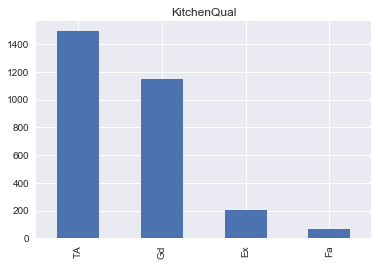

In [113]:
col = 'KitchenQual'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'TA'

### Electrical: Electrical system

Number of null value for: Electrical : 1


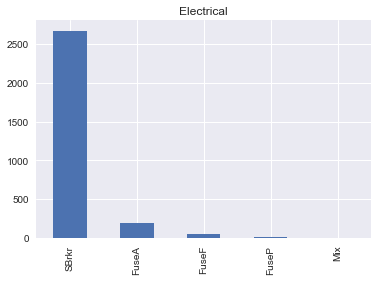

In [114]:
col = 'Electrical'
null_data = data[data[col].isnull()]
print("Number of null value for:", col, ":", len(null_data))
data[col].value_counts().plot(kind='bar', subplots=True)
data.loc[data[col].isnull(), col] = 'SBrkr'

### Fill all missing value of string columns with None

In [49]:
object_data.fillna(value='None', inplace=True)
combine_data.update(object_data)
combine_data.head(20)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0    1          60       RL         65.0     8450   Pave  None      Reg   
      1    2          20       RL         80.0     9600   Pave  None      Reg   
      2    3          60       RL         68.0    11250   Pave  None      IR1   
      3    4          70       RL         60.0     9550   Pave  None      IR1   
      4    5          60       RL         84.0    14260   Pave  None      IR1   
      5    6          50       RL         85.0    14115   Pave  None      IR1   
      6    7          20       RL         75.0    10084   Pave  None      Reg   
      7    8          60       RL          NaN    10382   Pave  None      IR1   
      8    9          50       RM         51.0     6120   Pave  None      Reg   
      9   10         190       RL         50.0     7420   Pave  None      Reg   
      10  11          20       RL         70.0    11200   Pave  None      Reg   
      11  12          60       RL         85.0    11924   Pave  None      IR1   
      12  13          20       RL          NaN    12968   Pave  None      IR2   
      13  14          20       RL         91.0    10652   Pave  None      IR1   
      14  15          20       RL          NaN    10920   Pave  None      IR1   
      15  16          45       RM         51.0     6120   Pave  None      Reg   
      16  17          20       RL          NaN    11241   Pave  None      IR1   
      17  18          90       RL         72.0    10791   Pave  None      Reg   
      18  19          20       RL         66.0    13695   Pave  None      Reg   
      19  20          20       RL         70.0     7560   Pave  None      Reg   

         LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  \
train 0          Lvl    AllPub      ...                 0        0   None   
      1          Lvl    AllPub      ...                 0        0   None   
      2          Lvl    AllPub      ...                 0        0   None   
      3          Lvl    AllPub      ...                 0        0   None   
      4          Lvl    AllPub      ...                 0        0   None   
      5          Lvl    AllPub      ...                 0        0   None   
      6          Lvl    AllPub      ...                 0        0   None   
      7          Lvl    AllPub      ...                 0        0   None   
      8          Lvl    AllPub      ...                 0        0   None   
      9          Lvl    AllPub      ...                 0        0   None   
      10         Lvl    AllPub      ...                 0        0   None   
      11         Lvl    AllPub      ...                 0        0   None   
      12         Lvl    AllPub      ...               176        0   None   
      13         Lvl    AllPub      ...                 0        0   None   
      14         Lvl    AllPub      ...                 0        0   None   
      15         Lvl    AllPub      ...                 0        0   None   
      16         Lvl    AllPub      ...                 0        0   None   
      17         Lvl    AllPub      ...                 0        0   None   
      18         Lvl    AllPub      ...                 0        0   None   
      19         Lvl    AllPub      ...                 0        0   None   

          Fence MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
train 0    None        None       0      2    2008        WD         Normal  
      1    None        None       0      5    2007        WD         Normal  
      2    None        None       0      9    2008        WD         Normal  
      3    None        None       0      2    2006        WD        Abnorml  
      4    None        None       0     12    2008        WD         Normal  
      5   MnPrv        Shed     700     10    2009        WD         Normal  
      6    None        None       0      8    2007        WD         Normal  
      7    None        Shed     350     11    2009        WD      

### Transform object data

In [46]:
object_data_standardlized = object_data.apply(
            LabelEncoder().fit_transform)